In [1]:
import ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from scipy import stats

Read in OHLC Data & Calculate Simple/Objective Indicators

In [2]:
time_interval_in_minutes = 5

btc_usdt_df = pd.read_csv('data/BTCUSDT.csv')
eth_usdt_df = pd.read_csv('data/ETHUSDT.csv')

dataframes = [btc_usdt_df, eth_usdt_df]

for df in dataframes:
    df.columns = map(str.lower, df.columns)
    df.drop(['close time', 'volume', 'taker buy base', 'taker buy quote', 'ignore'], axis=1, inplace=True)
    df.rename(columns={'quote asset volume': 'volume_usd', 'number of trades': 'num_trades', 'open time': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['sma50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['sma100'] = ta.trend.sma_indicator(df['close'], window=100)
    df['sma200'] = ta.trend.sma_indicator(df['close'], window=200)
    df['date'] = df['time'].dt.date
    df['vwap'] = df.groupby('date').apply(lambda x: (x['close'] * x['volume_usd']).cumsum() / x['volume_usd'].cumsum()).reset_index(level=0, drop=True)
    df.drop('date', axis=1, inplace=True)
    df['hlc_3'] = (df['high'] + df['low'] + df['close'])/3
    df['dist_to_sma50'] = df['hlc_3'] - df['sma50']
    df['dist_to_sma100'] = df['hlc_3'] - df['sma100']
    df['dist_to_sma200'] = df['hlc_3'] - df['sma200']
    df['dist_to_vwap'] = df['hlc_3'] - df['vwap']
    df[['atr', 'rsi', 'sma50', 'sma100','sma200']] = df[['atr', 'rsi', 'sma50', 'sma100','sma200']].round(2)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
# Don't want to use whole 250k rows while testing code.
btc_usdt_df = btc_usdt_df.head(20000)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

Define & Calculate Complex/Subjective Indicators

In [ ]:
########### find_horizontal_resistance_lines_and_touch_points ###########

#--> Identifies an "origin" green candle for resistance line starting point. 
#--> Defines the resistance 'line_price' as a weighted mean of the origin candle's high and close prices. 
# (This is superior to HLC/3 because we are only interested in the high wicks for resistance lines). 
#--> The 'waiting_period' and the 'waiting_candles' is a way to separate 'clumped' candle touches to have min # candles between origin point and 2nd touch. 
#--> Checks the following candles for touch points, using % of atr as wiggle room to define an acceptable range for touch points.
#--> Makes sure there are no overlapping lines during line creation.

########### find_horizontal_resistance_lines_and_touch_points ###########

In [3]:
def find_horizontal_resistance_lines_and_touch_points(df):
    resistance_lines = []
    i = 0
    waiting_period = 10

    while i < len(df) - waiting_period: 
        origin_candle = df.iloc[i]

        if origin_candle['close'] > origin_candle['open']:
            line_price = 0.6 * origin_candle['close'] + 0.4 * origin_candle['high'] 
            touch_points = {}
            touch_prices = {}
            last_touch_point_index = i

            waiting_candles = df.iloc[i+1:i+waiting_period+1]
            waiting_candles_upper_range = line_price + (0.5 * waiting_candles['atr'])
            waiting_candles_line_price = 0.6 * waiting_candles[['close', 'open']].max(axis=1) + 0.4 * waiting_candles['high']
            
            if any(waiting_candles_line_price > waiting_candles_upper_range):
                i += 1
                continue

            for j in range(i+waiting_period, len(df)):  
                candle = df.iloc[j]
                upper_range = line_price + (0.5 * candle['atr'])
                lower_range = line_price - (0.5 * candle['atr'])
                bottom_limit = line_price - (5 * candle['atr'])
                candle_line_price = 0.6 * candle[['close', 'open']].max() + 0.4 * candle['high']
                candle_line_price_bottom = 0.6 * candle[['close', 'open']].min() + 0.4 * candle['low']

                if j - last_touch_point_index >= waiting_period and lower_range <= candle_line_price <= upper_range:
                    touch_points[f'touch_point_{len(touch_points)+2}'] = candle['time']
                    touch_prices[f'touch_point_{len(touch_prices)+2}_price'] = candle_line_price
                    last_touch_point_index = j

                if candle_line_price > upper_range or candle_line_price_bottom < bottom_limit:
                    if len(touch_points) > 0:
                        line = {'initial_point': origin_candle['time'], 'end_of_line': candle['time'], 'line_price': line_price}
                        line.update(touch_points)
                        line.update(touch_prices)
                        resistance_lines.append(line)
                    i = j + 1
                    break
            else:
                i += 1
        else:
            i += 1

    return pd.DataFrame(resistance_lines)

resistance_lines_df = find_horizontal_resistance_lines_and_touch_points(btc_usdt_df)

In [4]:
# Add columns
time_interval_in_minutes = 5
resistance_lines_df['line_length'] = (resistance_lines_df['end_of_line'] - resistance_lines_df['initial_point']).dt.total_seconds() / (time_interval_in_minutes * 60)
resistance_lines_df['line_length'] = resistance_lines_df['line_length'].astype(int)
resistance_lines_df['3rd_touch_bool'] = resistance_lines_df['touch_point_3'].notna()
resistance_lines_df['num_touch_points'] = resistance_lines_df.filter(regex='touch_point_\d+$').count(axis=1) + 1

# Sort columns
static_columns = ['initial_point', 'end_of_line', 'line_length', 'line_price', 'num_touch_points', '3rd_touch_bool']
touch_point_columns = [col for col in resistance_lines_df.columns if 'touch_point' in col and col != 'num_touch_points']
touch_point_columns.sort(key=lambda x: int(x.split('_')[-2]) if x.split('_')[-1] == 'price' else int(x.split('_')[-1]))
ordered_columns = static_columns + touch_point_columns
resistance_lines_df = resistance_lines_df[ordered_columns]
resistance_lines_df.head(10)

,initial_point,end_of_line,line_length,line_price,num_touch_points,3rd_touch_bool,touch_point_2,touch_point_2_price,touch_point_3,touch_point_3_price,touch_point_4,touch_point_4_price,touch_point_5,touch_point_5_price,touch_point_6,touch_point_6_price,touch_point_7,touch_point_7_price
0,2020-12-17 06:25:00,2020-12-17 07:20:00,11,22270.064,2,False,2020-12-17 07:15:00,22288.760,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,2020-12-17 09:25:00,2020-12-17 13:05:00,44,23162.428,2,False,2020-12-17 12:55:00,23169.594,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
2,2020-12-17 13:35:00,2020-12-17 16:05:00,30,23326.852,2,False,2020-12-17 15:50:00,23270.470,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
3,2020-12-17 16:30:00,2020-12-17 18:15:00,21,23642.482,2,False,2020-12-17 17:20:00,23587.012,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
4,2020-12-17 20:50:00,2020-12-17 22:00:00,14,22721.138,2,False,2020-12-17 21:40:00,22696.168,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
5,2020-12-17 22:45:00,2020-12-18 02:15:00,42,23044.328,3,True,2020-12-18 01:15:00,22996.666,2020-12-18 02:05:00,23065.744,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
6,2020-12-18 05:05:00,2020-12-18 06:05:00,12,23006.120,2,False,2020-12-18 06:00:00,22977.098,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
7,2020-12-18 14:00:00,2020-12-18 16:50:00,34,22690.784,2,False,2020-12-18 16:35:00,22687.952,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
8,2020-12-18 17:45:00,2020-12-18 21:00:00,39,22800.496,3,True,2020-12-18 18:45:00,22774.192,2020-12-18 20:00:00,22776.656,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9,2020-12-18 21:25:00,2020-12-18 23:50:00,29,23063.728,2,False,2020-12-18 23:45:00,23056.972,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


Define a Trading Strategy

In [12]:
########### trading_strategy ###########

#--> Calculates the trading results based on returns calculated.
#--> Uses the closing price as the 3rd touch point as the entry point for the trade.
#--> Defines the stop loss level as 1.3*atr below the entry, and the take profit level as 3*atr above the entry.
#--> Iterates through the sliced data to determine whether the stop loss or take profit was hit first, or neither was hit during the period.
#--> Adds columns to the resistance line DataFrame to store the entry price, stop loss, take profit, the result, timestamp of target hit

########### trading_strategy ###########

In [5]:
def trading_strategy(df, resistance_lines_df):

    trade_results_df = pd.DataFrame(columns=['entry_price', 'entry_time', 'sl', 'tp', 'result', 'exit_time'])

    # Skip rows with less than 3 touch points
    for idx, row in resistance_lines_df.iterrows():
        if row['num_touch_points'] < 3:
            continue
        
        third_point = row['touch_point_3']
        third_point_index = df[df['time'] == third_point].index[0]

        # Entry is the open of the next candles close (after the 3rd touch point).
        entry_price = df.iloc[third_point_index + 1]['open']
        entry_time = df.iloc[third_point_index + 1]['time']

        # The slice should start from the next row after the entry_time
        slice_df = df.iloc[third_point_index + 1:]

        result = 'None'
        exit_time = 'None'

        # Iterate through the sliced DataFrame to check whether the stop loss or take profit was hit.
        for _, candle in slice_df.iterrows():
            atr = candle['atr']
            sl_level = entry_price - 1.3 * atr
            tp_level = entry_price + 3 * atr

            if candle['high'] >= tp_level:
                result = 'Take Profit'
                exit_time = candle['time']
                break
            elif candle['low'] <= sl_level:
                result = 'Stop Loss'
                exit_time = candle['time']
                break

        if result == 'None':
            result = 'No Target Hit'

        new_row = pd.DataFrame({'entry_price': [entry_price], 'entry_time': [entry_time], 'sl': [sl_level], 'tp': [tp_level], 'result': [result], 'exit_time': [exit_time]})
        trade_results_df = pd.concat([trade_results_df, new_row], ignore_index=True)

    return trade_results_df

trade_results_df = trading_strategy(btc_usdt_df, resistance_lines_df)

In [6]:
# Add columns
trade_results_df['pos_size'] = 10000
trade_results_df['fee'] = 0.001 * trade_results_df['pos_size']
trade_results_df['trade_length_minutes'] = (trade_results_df['exit_time'] - trade_results_df['entry_time']).dt.total_seconds() / 60
trade_results_df['trade_length_candles'] = trade_results_df['trade_length_minutes'] / time_interval_in_minutes
trade_results_df[['trade_length_candles', 'trade_length_minutes']] = trade_results_df[['trade_length_candles', 'trade_length_minutes']].astype(int)
trade_results_df['exit_price'] = np.where(trade_results_df['result'] == 'Take Profit', trade_results_df['tp'], 
                                 np.where(trade_results_df['result'] == 'Stop Loss', trade_results_df['sl'], np.nan))
trade_results_df['reward'] = ((trade_results_df['tp'] - trade_results_df['entry_price']) / trade_results_df['entry_price'])
trade_results_df['risk'] = ((trade_results_df['sl'] - trade_results_df['entry_price']) / trade_results_df['entry_price'])
trade_results_df['rr_ratio'] = abs(trade_results_df['reward'] / trade_results_df['risk'])
trade_results_df['pl_b4_fee'] = (trade_results_df['exit_price'] - trade_results_df['entry_price']) * (trade_results_df['pos_size'] / trade_results_df['entry_price'])
trade_results_df['net_pl_with_fee'] = trade_results_df['pl_b4_fee'] - trade_results_df['fee']

# Sort columns
sorted_columns = ['entry_time', 'exit_time', 'trade_length_minutes', 'trade_length_candles',
                 'entry_price', 'exit_price', 'sl', 'tp', 'result', 'net_pl_with_fee',
                 'fee', 'pl_b4_fee', 'pos_size', 'reward', 'risk', 'rr_ratio']
trade_results_df = trade_results_df[sorted_columns]
trade_results_df.head(10)

,entry_time,exit_time,trade_length_minutes,trade_length_candles,entry_price,exit_price,sl,tp,result,net_pl_with_fee,fee,pl_b4_fee,pos_size,reward,risk,rr_ratio
0,2020-12-18 02:10:00,2020-12-18 03:00:00,50,10,23064.57,22945.880,22945.880,23338.47,Stop Loss,-61.459880,10.0,-51.459880,10000,0.011875,-0.005146,2.307692
1,2020-12-18 20:05:00,2020-12-18 20:20:00,15,3,22768.59,22705.397,22705.397,22914.42,Stop Loss,-37.754463,10.0,-27.754463,10000,0.006405,-0.002775,2.307692
2,2020-12-19 02:00:00,2020-12-19 02:40:00,40,8,23046.75,23199.090,22980.736,23199.09,Take Profit,56.100426,10.0,66.100426,10000,0.006610,-0.002864,2.307692
3,2020-12-19 12:35:00,2020-12-19 14:00:00,85,17,23056.31,23275.250,22961.436,23275.25,Take Profit,84.958820,10.0,94.958820,10000,0.009496,-0.004115,2.307692
4,2020-12-20 15:10:00,2020-12-20 15:45:00,35,7,23583.40,23812.810,23483.989,23812.81,Take Profit,87.276050,10.0,97.276050,10000,0.009728,-0.004215,2.307692
5,2020-12-20 19:45:00,2020-12-20 20:20:00,35,7,23889.99,24095.910,23800.758,24095.91,Take Profit,76.195097,10.0,86.195097,10000,0.008620,-0.003735,2.307692
6,2020-12-21 00:20:00,2020-12-21 02:10:00,110,22,23547.90,23755.440,23457.966,23755.44,Take Profit,78.135248,10.0,88.135248,10000,0.008814,-0.003819,2.307692
7,2020-12-21 18:05:00,2020-12-21 18:05:00,0,0,22894.75,22664.572,22664.572,23425.93,Stop Loss,-110.537459,10.0,-100.537459,10000,0.023201,-0.010054,2.307692
8,2020-12-22 02:40:00,2020-12-22 03:15:00,35,7,22886.41,22776.703,22776.703,23139.58,Stop Loss,-57.935434,10.0,-47.935434,10000,0.011062,-0.004794,2.307692
9,2020-12-22 09:05:00,2020-12-22 09:35:00,30,6,22780.59,22666.138,22666.138,23044.71,Stop Loss,-60.241017,10.0,-50.241017,10000,0.011594,-0.005024,2.307692


Analyze Trading Strategy

In [7]:
trade_stats_df = pd.DataFrame({
    'pl total': [trade_results_df['net_pl_with_fee'].sum()],
    'avg_pl_per_trade': [trade_results_df['net_pl_with_fee'].mean()],
    'num_loses': [trade_results_df['result'].value_counts().get('Stop Loss', 0)],
    'num_wins': [trade_results_df['result'].value_counts().get('Take Profit', 0)],
    'total_trades': [trade_results_df['result'].count()],
    'win_pct': [trade_results_df['result'].value_counts().get('Take Profit', 0) / trade_results_df['result'].count()],
    'loss_pct': [trade_results_df['result'].value_counts().get('Stop Loss', 0) / trade_results_df['result'].count()],
    'avg_trade_length': [trade_results_df['trade_length_candles'].mean()],
    'max_trade_length': [trade_results_df['trade_length_candles'].max()],
    'min_trade_length': [trade_results_df['trade_length_candles'].min()],
    'avg_rr_ratio': [trade_results_df['rr_ratio'].mean()],
    'min_rr_ratio': [trade_results_df['rr_ratio'].min()],
    'max_rr_ratio': [trade_results_df['rr_ratio'].max()],
})

trade_stats_df

# Min length trade of 0 is working as intended --> exits that happened within the entry candle, since entries are on the candles open.

,pl total,avg_pl_per_trade,num_loses,num_wins,total_trades,win_pct,loss_pct,avg_trade_length,max_trade_length,min_trade_length,avg_rr_ratio,min_rr_ratio,max_rr_ratio
0,199.868164,1.940468,61,42,103,0.407767,0.592233,8.087379,29,0,2.307692,2.307692,2.307692


In [10]:
########### returns_from_entry ###########
#--> 'e' stands for entry.
#--> Returns are calculated as (current hlc/3) - entry_price
#--> Good for determining a trading strategy or backtesting/optimizing for SL/TP/etc. (Use bulk data eventually)
#--> 'e+0' will reflect the price change that happened within the 'entry_time' candle itself, (since trades executed on open of candle)

########### returns_from_entry ###########

In [8]:
def returns_from_entry(btc_usdt_df, trade_results_df):
    analysis_dict = {}

    for idx, row in trade_results_df.iterrows():

        entry_price = row['entry_price']
        entry_time = row['entry_time']
        
        start_idx = btc_usdt_df.loc[btc_usdt_df['time'] == entry_time].index[0]
        end_idx = min(start_idx + 200, len(btc_usdt_df) - 1)
        slice_df = btc_usdt_df.iloc[start_idx:end_idx]

        trade_df = slice_df[['hlc_3']].copy()
        trade_df['returns'] = trade_df['hlc_3'].apply(lambda x: x - entry_price)

        trade_df.drop(columns=['hlc_3'], inplace=True)
        trade_df.reset_index(drop=True, inplace=True)
        trade_df.index = 'e+' + trade_df.index.astype(str)

        analysis_dict[idx] = trade_df

    return analysis_dict

analysis_dict = returns_from_entry(btc_usdt_df, trade_results_df)

In [10]:
def create_returns_plot(analysis_dict):
    fig = go.Figure()

    for trade, trade_df in analysis_dict.items():
        returns_trace = go.Scatter(x=trade_df.index, y=trade_df['returns'], mode='lines', name=f'Trade {trade}', line=dict(color='#FFD700'), opacity=0.3)
        fig.add_trace(returns_trace)

    fig.add_hline(y=0, line=dict(color='blue', width=2, dash='dash'))

    fig.update_layout(title='Returns Over Time', xaxis_title="Candles after Entry", yaxis=dict(title='Returns', side='left', color='white'),
        showlegend=True,
        template="plotly_dark"
    )
    fig.show()

create_returns_plot(analysis_dict)

In [11]:
# Start with $100k
portfolio_value = 100000
trades_df = trade_results_df.copy()

trades_df['cumulative_pl'] = trades_df['net_pl_with_fee'].cumsum().shift(fill_value=0)
trades_df['cumulative_pl'] += portfolio_value
trades_df['running_max'] = trades_df['cumulative_pl'].cummax()
trades_df['drawdown'] = trades_df['running_max'] - trades_df['cumulative_pl']
max_drawdown = trades_df['drawdown'].max()

print("Maximum Drawdown: $", round(max_drawdown, 2))
fig = go.Figure()
fig.add_trace(go.Scatter(x=trades_df.index, y=trades_df['cumulative_pl'], mode='lines', name='Portfolio Value'))
fig.update_yaxes(tickformat=",.2f")
fig.update_layout(title='Cumulative Portfolio Value', xaxis_title='Trade Number', yaxis_title='Portfolio Value', showlegend=False, template="plotly_dark")
fig.show()

Maximum Drawdown: $ 1343.84


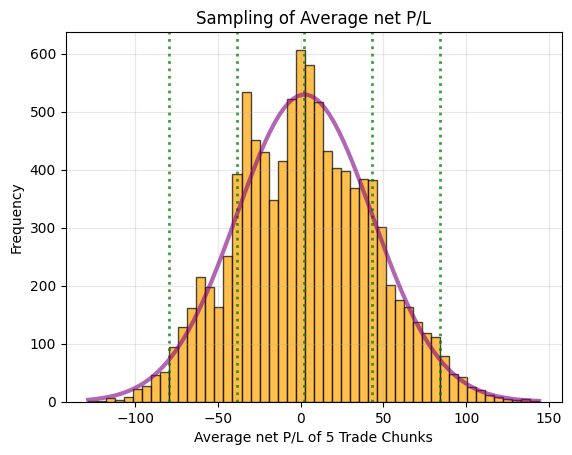

Mean: +$2.27
Average net P/L ONE std below and above the mean: (-$38.77, +$43.30)
Average net P/L TWO std below and above the mean: (-$79.80, +$84.33)


In [12]:
# Random sampling of 5 trades, for 10,000 iterations to get a distribution of random trades.
sample_size=5
iterations=10000

def random_sample_avg_pl(trade_results_df, sample_size, iterations):
    all_pl = trades_df['net_pl_with_fee'].tolist()
    avg_pl_samples = []

    for _ in range(iterations):
        random_pl_sample = random.sample(all_pl, sample_size)
        avg_pl_samples.append(np.mean(random_pl_sample))
    return avg_pl_samples

avg_pl_samples = random_sample_avg_pl(trade_results_df, sample_size, iterations)

# Fit a Gaussian distribution, returning the mean and standard deviation. Generate 100 evenly spaced numbers in an array between min and max values of avg_pl_samples
mu, sigma = stats.norm.fit(avg_pl_samples)
x = np.linspace(min(avg_pl_samples), max(avg_pl_samples), 100)

# Probability Density Function, & calculates std's from the mean.
pdf = stats.norm.pdf(x, mu, sigma)
one_std_left = mu - sigma
one_std_right = mu + sigma
two_std_left = mu - 2*sigma
two_std_right = mu + 2*sigma

# Plot vertical lines for the mean and std's
plt.axvline(mu, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(one_std_left, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(one_std_right, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(two_std_left, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(two_std_right, color='green', linestyle='dotted', linewidth=2, alpha=0.75)

# Plot the histogram
n, bins, patches = plt.hist(avg_pl_samples, bins='auto', color='orange', edgecolor='black', alpha=0.7)

# Rescale the Gaussian curve from probability density to the same frequency representation as the histogram
bin_width = bins[1] - bins[0]
pdf_rescaled = pdf * len(avg_pl_samples) * bin_width

# Plot rescaled Gaussian curve
plt.plot(x, pdf_rescaled, color='purple', alpha=0.6, linewidth=3)
plt.xlabel(f'Average net P/L of {sample_size} Trade Chunks')
plt.ylabel('Frequency')
plt.title('Sampling of Average net P/L')
plt.grid(True, alpha=0.3)
plt.show()

# Formatting the text output
def format_value(value):
    return f"{'+' if value >= 0 else '-'}${'{:.2f}'.format(abs(value))}"
print(f"Mean: {format_value(mu)}")
print(f"Average net P/L ONE std below and above the mean: ({format_value(one_std_left)}, {format_value(one_std_right)})")
print(f"Average net P/L TWO std below and above the mean: ({format_value(two_std_left)}, {format_value(two_std_right)})")

In [13]:
# Slices 'btc_usdt_df' into manageable plotting amount.
plt_btc_usdt_df = btc_usdt_df.head(4000)

last_timestamp = plt_btc_usdt_df['time'].iloc[-1]

# Corresponds the last timestamp of price data chunk to the trade results and resistance lines.
mask = resistance_lines_df['end_of_line'] <= last_timestamp
mask_two = trade_results_df['exit_time'] <= last_timestamp
plt_resistance_lines_df = resistance_lines_df[mask]
plt_trade_results_df = trade_results_df[mask_two]

In [14]:
# PLOTLY CRASHES IF USING TOO MANY ROWS, THIS IS JUST TO MAKE SURE TRADES LOOK RIGHT AND LOOK AT SOME TRADES
# PLOTLY CRASHES IF USING TOO MANY ROWS, THIS IS JUST TO MAKE SURE TRADES LOOK RIGHT AND LOOK AT SOME TRADES
# PLOTLY CRASHES IF USING TOO MANY ROWS, THIS IS JUST TO MAKE SURE TRADES LOOK RIGHT AND LOOK AT SOME TRADES

# Candlestick plot (With the horizontal lines, all the line touch points, trade entry, trade exit)

fig = make_subplots(specs=[[{"secondary_y": True}]])

candlesticks = go.Candlestick(x=plt_btc_usdt_df['time'], open=plt_btc_usdt_df['open'], high=plt_btc_usdt_df['high'], low=plt_btc_usdt_df['low'], close=plt_btc_usdt_df['close'], name='Candlesticks')

line_origin = go.Scatter(x=plt_resistance_lines_df['initial_point'], y=plt_resistance_lines_df['line_price'], mode='markers', name='Line Origin', marker=dict(color='#39FF14', size=7))
line_end = go.Scatter(x=plt_resistance_lines_df['end_of_line'], y=plt_resistance_lines_df['line_price'], mode='markers', name='Line End', marker=dict(color='#39FF14', size=7))

entries = go.Scatter(x=plt_trade_results_df['entry_time'], y=plt_trade_results_df['entry_price'], mode='markers', name='Entry', marker=dict(color='#FFD700', size=7))
exits = go.Scatter(x=plt_trade_results_df['exit_time'], y=plt_trade_results_df['exit_price'], mode='markers', name='Exit', marker=dict(color='#FFD700', size=7))
atr = go.Scatter(x=plt_btc_usdt_df['time'], y=plt_btc_usdt_df['atr'], mode='lines', name='ATR', line=dict(color='purple'), opacity=0.6)

fig.add_trace(candlesticks, secondary_y=False)
fig.add_trace(line_origin, secondary_y=False)
fig.add_trace(line_end, secondary_y=False)

# Adds all the touch points starting with 'touch_point_2'
for i in range(2, len(plt_resistance_lines_df.columns)):
    touch_point_column = 'touch_point_' + str(i)
    touch_price_column = 'touch_point_' + str(i) + '_price'

    if touch_point_column in plt_resistance_lines_df.columns:
        touch_points = go.Scatter(x=plt_resistance_lines_df[touch_point_column], y=plt_resistance_lines_df[touch_price_column], mode='markers', name=f'Touch Point {i}', marker=dict(color='#B200ED', size=7))
        fig.add_trace(touch_points, secondary_y=False)

fig.add_trace(entries, secondary_y=False)
fig.add_trace(exits, secondary_y=False)
fig.add_trace(atr, secondary_y=True)

fig.update_layout(title='BTC/USDT', xaxis_title='Time', template="plotly_dark", legend=dict(y=1.2, font=dict(size=12)))
fig.update_yaxes(title_text='Price', secondary_y=False, tickformat="$,.2f", autorange=True, fixedrange=False)
fig.update_yaxes(title_text='ATR', secondary_y=True)

# Adds the horizontal resistance lines to graph. Iterates through each row of the resistance_df.
for _, row in plt_resistance_lines_df.iterrows():
    start_time = row['initial_point']
    end_time = row['end_of_line']
    price = row['line_price']
    
    fig.add_shape(type="line", x0=start_time, y0=price, x1=end_time, y1=price, line=dict(color='#39FF14', width=2), xref='x', yref='y')

fig.show()